In [26]:
import pandas as pd
import numpy as np
from collections import Counter
import re

from sklearn import preprocessing

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

import seaborn as sns
sns.set()
%matplotlib inline
import string

import os 
from datetime import datetime
import random
import math

from sklearn.cross_validation import train_test_split

In [27]:
df = pd.read_csv('train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [28]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


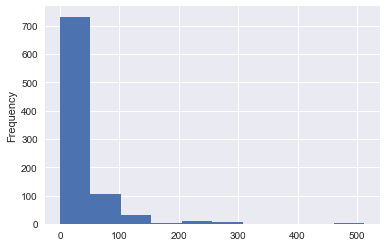

In [29]:
df['Fare'].plot(kind='hist')

In [30]:
ranges = pd.cut(df['Fare'], 5)
df_Fare_discretization = pd.DataFrame(list(Counter(ranges).values()), columns=['count'], index= list(Counter(ranges).keys()))
df_Fare_discretization

,count
"(204.932, 307.398]",17
"(-0.512, 102.466]",838
"(409.863, 512.329]",3
"(102.466, 204.932]",33


In [31]:
ranges = pd.qcut(df['Fare'], 5)
df_Fare_discretization = pd.DataFrame(list(Counter(ranges).values()), columns=['count'], index= list(Counter(ranges).keys()))
df_Fare_discretization

,count
"(7.854, 10.5]",184
"(39.688, 512.329]",176
"(10.5, 21.679]",172
"(-0.001, 7.854]",179
"(21.679, 39.688]",180


In [24]:
def preprocess(df):
    ## 處理None值
#      avg_age = df['Age'].mean() #作法一: 取平均值
#     avg_age = df['Age'].median() #作法二: 取中位數
#     作法三: 用相同的分布產生亂數塞入
    std = df['Age'].std()
    mean = df['Age'].mean()
    size = len(df[pd.isnull(df['Age'])])
    age_null_random_list = np.random.randint(mean - std, mean + std, size=size)
    df.loc[pd.isnull(df['Age']), 'Age'] = age_null_random_list
    
    # fare discretization
    def farecat(f):
        if f <= 16:
            cat = 0
        elif f > 17 and f <= 32:
            cat = 1
        elif f > 32 and f <= 48:
            cat = 2
        elif f < 48 and f <= 64:
            cat = 3
        elif f < 64 and f <= 80:
            cat = 4
        elif f < 80 and f <= 96:
            cat = 5
        else:
            cat = 6
        return cat

    # avg_fare
    fares_notnull = df[pd.notnull(df['Fare'])]['Fare']
    avg_fare = fares_notnull.median()

    # ticket
    ticket_cat = {}
    for ticket in df['Ticket']:
        if ticket.isdigit():
            ticket_cat[ticket] = 1
        elif ticket.startswith('A'):
            ticket_cat[ticket] = 2
        elif ticket.startswith('C'):
            ticket_cat[ticket] = 3
        elif ticket.startswith('F'):
            ticket_cat[ticket] = 4
        elif ticket.startswith('P'):
            ticket_cat[ticket] = 5
        elif ticket.startswith('SOTON'):
            ticket_cat[ticket] = 6
        elif ticket.startswith('STON'):
            ticket_cat[ticket] = 7
        elif ticket.startswith('S'):
            ticket_cat[ticket] = 8
        elif ticket.startswith('W'):
            ticket_cat[ticket] = 9
        else:
            ticket_cat[ticket] = 0
            
    ticket_cat1 = {}
    for num, name in enumerate(list(set([item.split()[0].replace(".", "").replace("/", "") for item in df['Ticket'] if not item.isdigit()]))):
        ticket_cat1[name] = num
    
    # cabin
    cabin_cat = {}
    for cabin in df['Cabin']:
        if pd.isnull(cabin):
            cabin_cat[cabin] = 0
        elif cabin.startswith('A'):
            cabin_cat[cabin] = 1
        elif cabin.startswith('B'):
            cabin_cat[cabin] = 2
        elif cabin.startswith('C'):
            cabin_cat[cabin] = 3
        elif cabin.startswith('D'):
            cabin_cat[cabin] = 4
        elif cabin.startswith('E'):
            cabin_cat[cabin] = 5
        else:
            cabin_cat[cabin] = 0
    
    # embarked
    embarked_cat = {}
    for embarked in df['Embarked']:
        if pd.isnull(embarked):
            embarked_cat[embarked] = 0
        elif embarked.startswith('S'):
            embarked_cat[embarked] = 0
        elif embarked.startswith('Q'):
            embarked_cat[embarked] = 1
        elif embarked.startswith('C'):
            embarked_cat[embarked] = 2
            
    # title
    title_mapping= {
        'Ms':"Miss",
        'Mlle':"Miss",
        'Miss':"Miss",
        'Mrs':"Mrs",
        'Mme':"Mrs",
        'MrsMartin(ElizabethL':"Mrs",
        'Mr':"Mr"
        }
    
    title_cat = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    
    # Name_with specail chars
    def withspecailchar(name):
        for char in name:
            if char in string.punctuation:
                return 1
        return 0
    
    def applyfun(row):
        # Normalization
        row['Fare'] = row['Fare'] if pd.notnull(row['Fare']) else avg_fare
        row['Fare_log10'] = math.log(row['Fare'], 10) if  row['Fare'] != 0 else 0
                
        # Transformation
        row['Cabin'] = cabin_cat.get(row['Cabin'])  ## 整理艙位的類別
        row['Ticket'] = ticket_cat.get(row['Ticket'])  ## 整理票券類別
        row['Embarked'] = embarked_cat.get(row['Embarked'])  ## 整出發地類別
        row['Sex'] = 1 if row['Sex'] == 'male' else 0  ## 性別
        row['Name_Length'] = len(row['Name'])  ## Name => Name_Length
        row['Name_With_Special_Char'] = withspecailchar(row['Name'].replace(',', "").replace('.', ""))  ## Name => Name_With_Special_Char
        call = re.search(r'\,.+\.', row['Name']).group(0).replace(",", "").replace(".", "").replace(" ", "")
        call_cat = title_cat.get(title_mapping.get(call, "Rare"))
        row['Title'] = call_cat  ## Name => Title

        # Discretization
        row['Fare_Cat'] = farecat(row['Fare'])
        
        # Integration
        row['Family_Size'] = row['SibSp'] + row['Parch']
        row['Is_Alone']= 1 if row['Family_Size'] == 1 else 0
        row['Is_Mother']= 1 if row['Parch'] > 1 and row['Age']>20 else 0

        return row
    
    df = df.apply(applyfun, axis=1)
    df.drop(['Name', 'Fare'], axis=1, inplace=True)
    return df

df = pd.read_csv('train.csv')
df = preprocess(df)

# 1. Data Description

In [5]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Fare_Cat', 'Family_Size',
       'Is_Alone', 'Name_Length', 'Name_With_Special_Char', 'Title'],
      dtype='object')

In [6]:
df.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fare_Cat,Family_Size,Is_Alone,Name_Length,Name_With_Special_Char,Title
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.647587,29.744299,0.523008,0.381594,2.017957,32.204208,0.648709,0.463524,1.303030,0.904602,0.180696,26.965208,0.217733,1.773288
std,257.353842,0.486592,0.836071,0.477990,13.559276,1.102743,0.806057,2.059702,49.693429,1.376792,0.791503,1.977452,1.613459,0.384982,9.281607,0.412937,1.143720
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,1.000000
25%,223.500000,0.000000,2.000000,0.000000,21.000000,0.000000,0.000000,1.000000,7.910400,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000,1.000000
50%,446.000000,0.000000,3.000000,1.000000,29.000000,0.000000,0.000000,1.000000,14.454200,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,0.000000,1.000000
75%,668.500000,1.000000,3.000000,1.000000,38.500000,1.000000,0.000000,2.000000,31.000000,0.000000,1.000000,1.000000,1.000000,0.000000,30.000000,0.000000,2.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,9.000000,512.329200,5.000000,2.000000,6.000000,10.000000,1.000000,82.000000,1.000000,5.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
PassengerId               891 non-null int64
Survived                  891 non-null int64
Pclass                    891 non-null int64
Sex                       891 non-null int64
Age                       891 non-null float64
SibSp                     891 non-null int64
Parch                     891 non-null int64
Ticket                    891 non-null int64
Fare                      891 non-null float64
Cabin                     891 non-null int64
Embarked                  891 non-null int64
Fare_Cat                  891 non-null int64
Family_Size               891 non-null int64
Is_Alone                  891 non-null int64
Name_Length               891 non-null int64
Name_With_Special_Char    891 non-null int64
Title                     891 non-null int64
dtypes: float64(2), int64(15)
memory usage: 118.4 KB


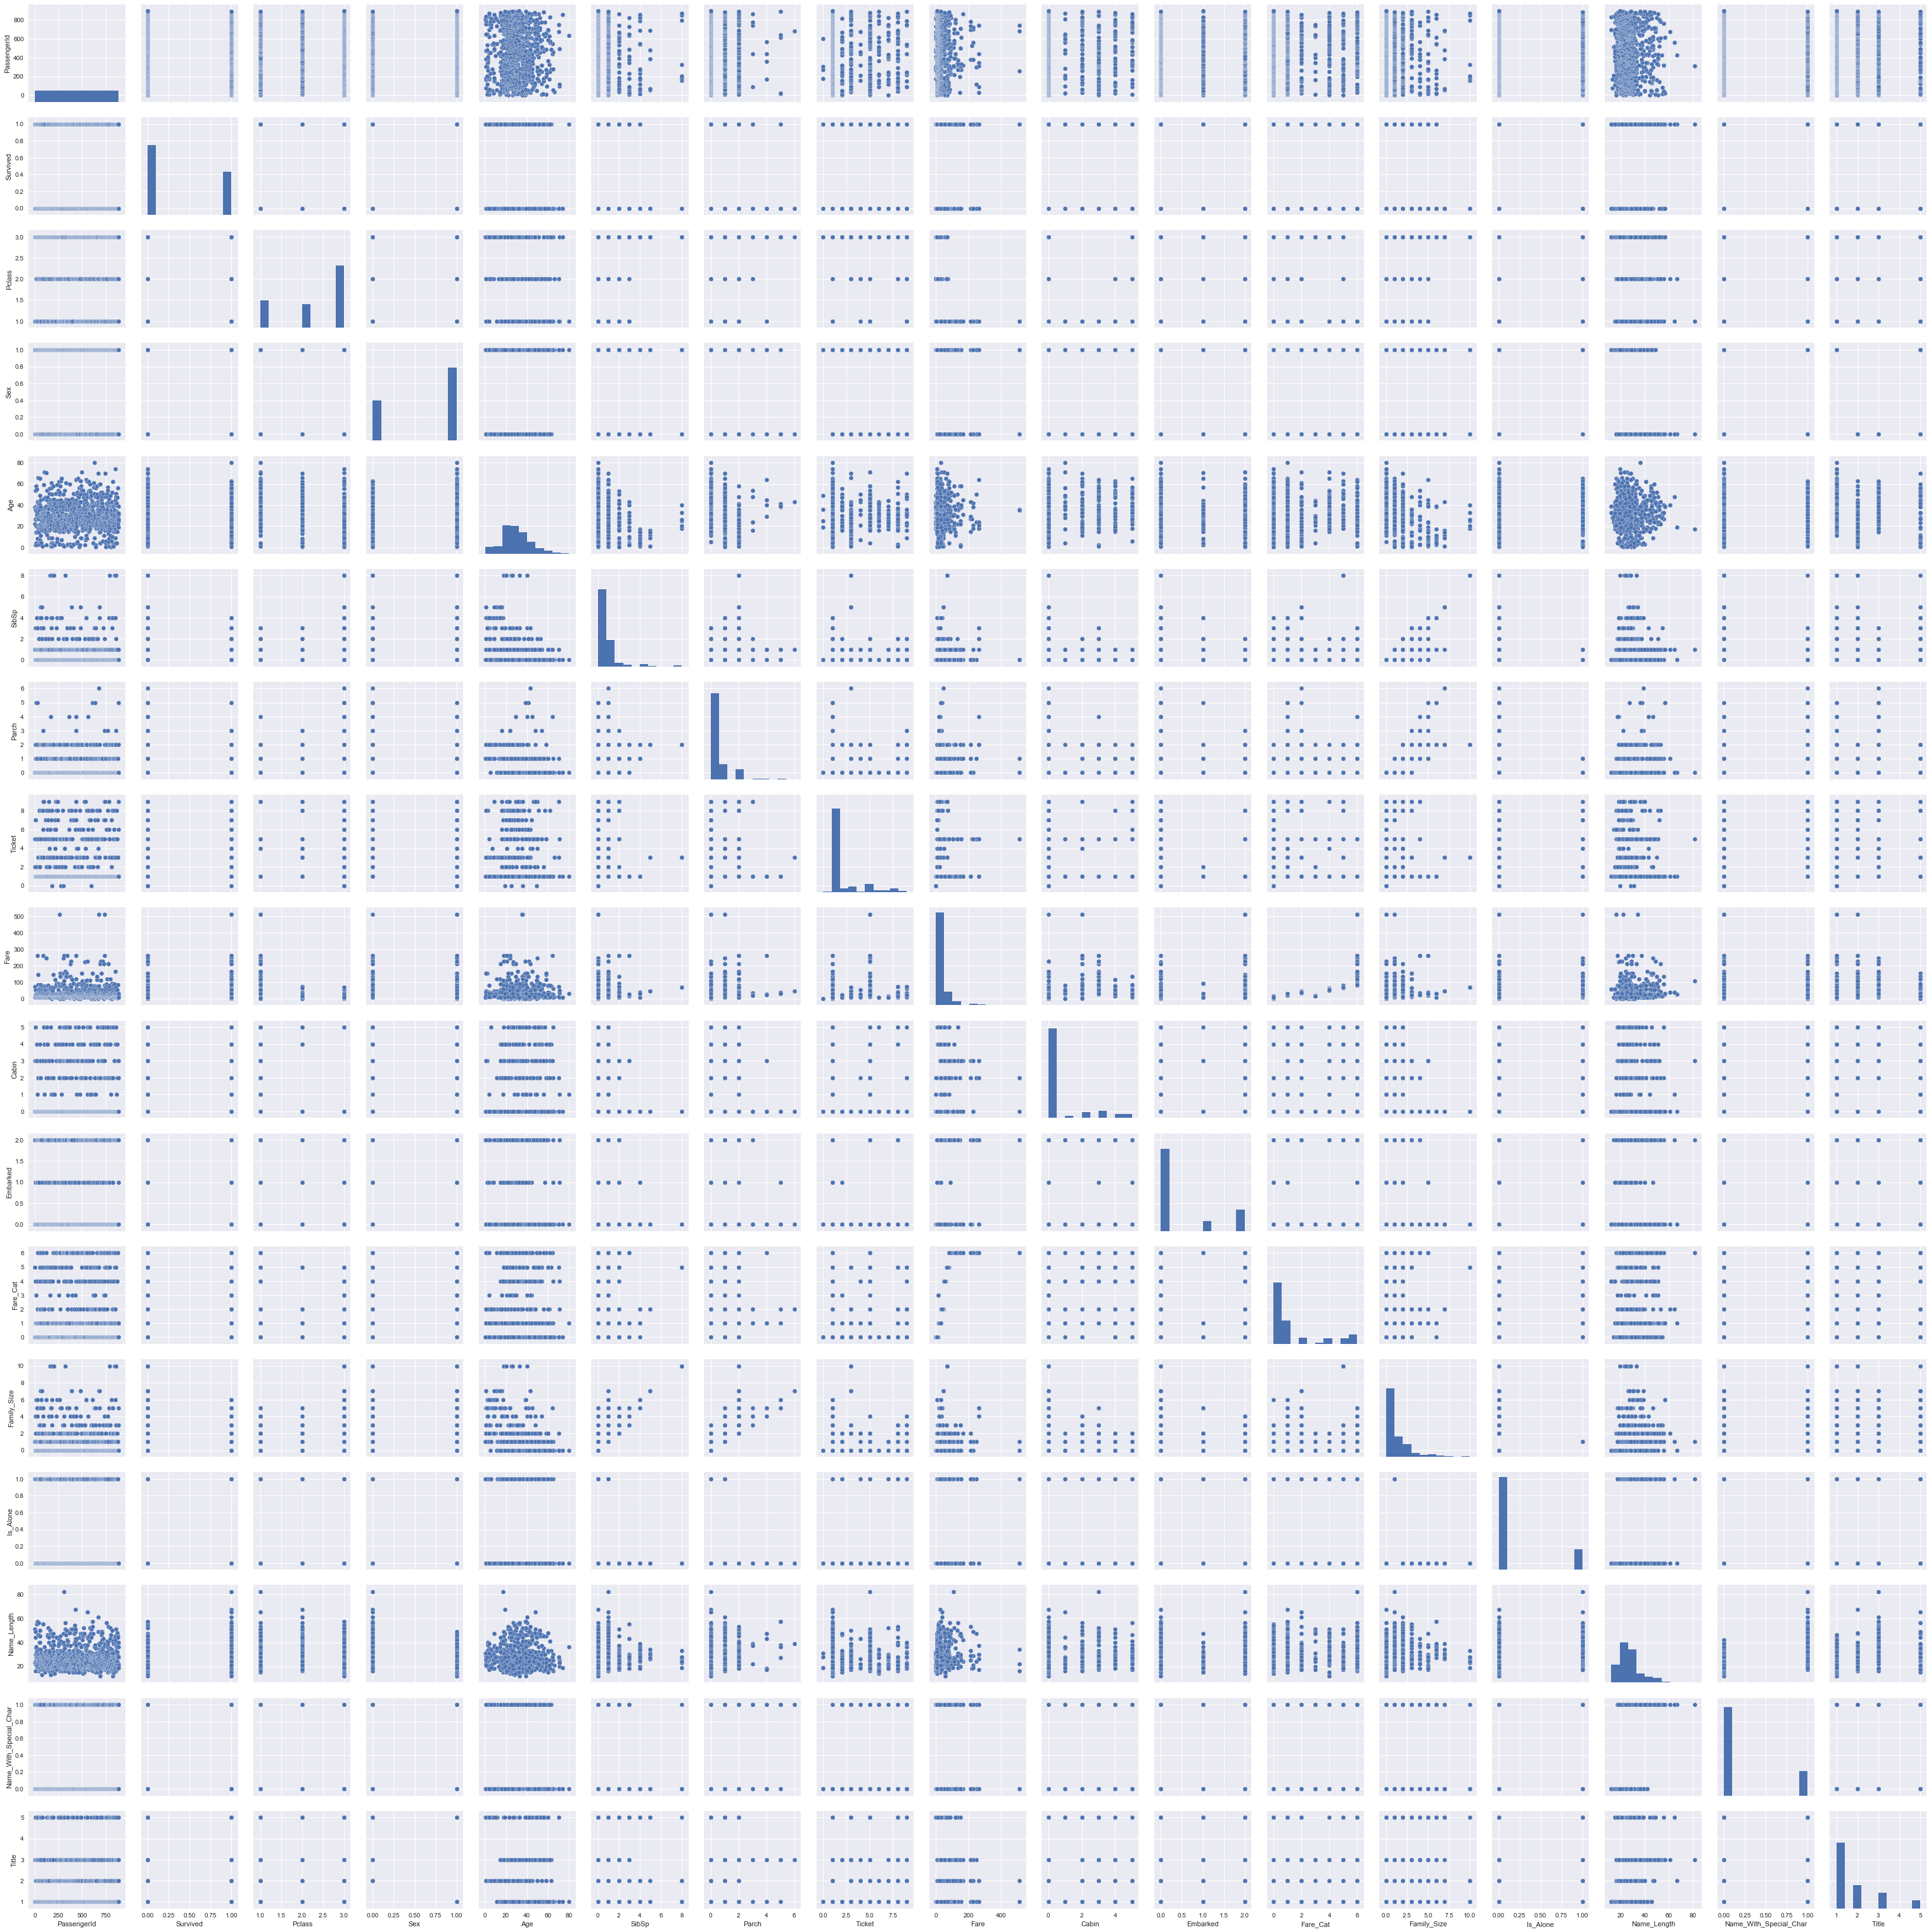

In [8]:
sns.pairplot(df)

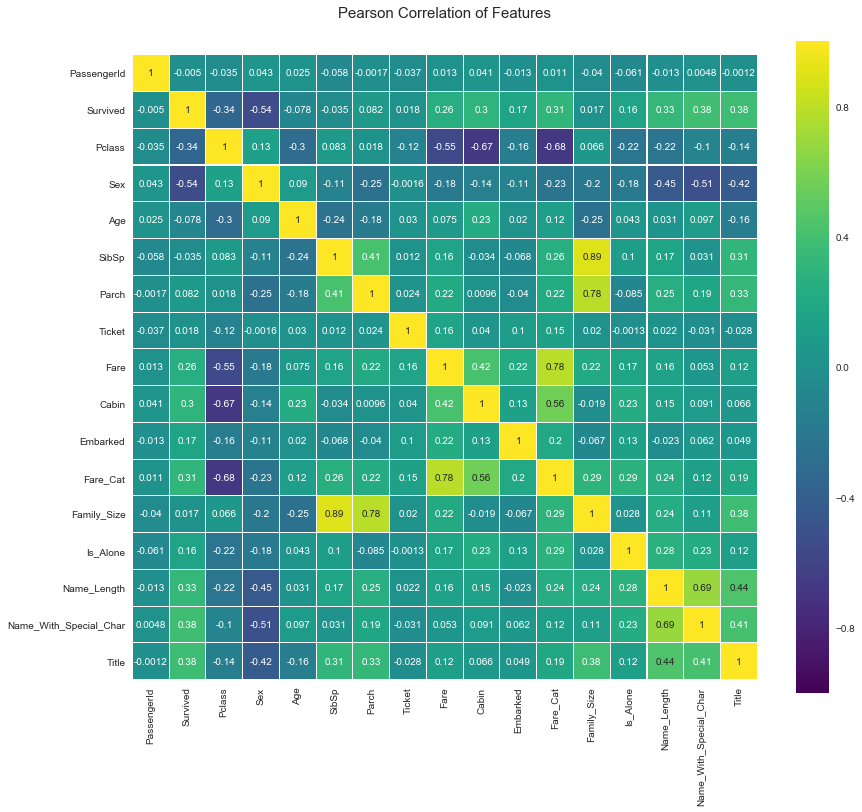

In [9]:
colormap = plt.cm.viridis
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

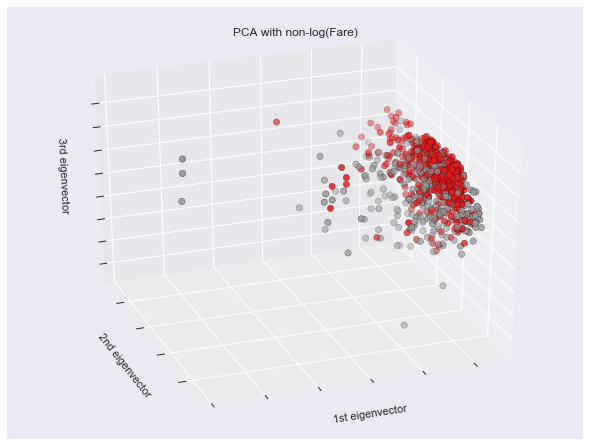

In [10]:
X = np.matrix(df.drop(['Survived','PassengerId'], axis=1))
Y = np.array(df['Survived'])

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)

X_reduced = PCA(n_components=3).fit_transform(X)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("PCA with non-log(Fare)")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()

# 2. Models

## SVM

In [11]:
# Input Data Preparation
X = np.matrix(df.drop(['Survived','PassengerId'], axis=1))
Y = np.array(df['Survived'])

print(X.shape)
print(Y.shape)
print(sum(Y)/len(Y))

(891, 15)
(891,)
0.383838383838


In [12]:
# Finally, we split some of the data off for validation
x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2, random_state=4242)

print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(712, 15)
(179, 15)
(712,)
(179,)


In [14]:
from sklearn.svm import SVC
svm = SVC(C=1, kernel='linear')
svm.fit(x_train, y_train) 

y_pred = svm.predict(x_train)
print("Train: Number of mislabeled points out of a total %d points : %d" % (x_train.shape[0], pd.Series(y_train != y_pred).astype(int).sum()))
y_pred = svm.predict(x_valid)
print("Valid: Number of mislabeled points out of a total %d points : %d" % (x_valid.shape[0], pd.Series(y_valid != y_pred).astype(int).sum()))

Train: Number of mislabeled points out of a total 712 points : 124
Valid: Number of mislabeled points out of a total 179 points : 37


## XGB

In [15]:
# plot decision tree
from xgboost import XGBClassifier

# fit model no training data
xgb1 = XGBClassifier(learning_rate=0.4, n_estimators=200)
xgb1.fit(x_train, y_train)

y_pred = xgb1.predict(x_train)
print("Number of mislabeled points out of a total %d points : %d" % (x_train.shape[0],(y_train != y_pred).sum()))
y_pred = xgb1.predict(x_train)
print("Number of mislabeled points out of a total %d points : %d" % (x_valid.shape[0], pd.Series(y_valid != y_pred).astype(int).sum()))

Number of mislabeled points out of a total 712 points : 12
Number of mislabeled points out of a total 179 points : 1


c:\users\jeremy\appdata\local\programs\python\python35\lib\site-packages\ipykernel\__main__.py:11: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


## Cross-Validation

In [16]:
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.04
## learning rate: Lower values generalize well.
params['max_depth'] = 4
## control over-fitting, higher depth specific to a particular sample.

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 200, watchlist, early_stopping_rounds=100, verbose_eval=10)

[0]	train-logloss:0.671901	valid-logloss:0.674359
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[10]	train-logloss:0.525111	valid-logloss:0.549087
[20]	train-logloss:0.443754	valid-logloss:0.485889
[30]	train-logloss:0.395892	valid-logloss:0.453807
[40]	train-logloss:0.36614	valid-logloss:0.438099
[50]	train-logloss:0.344736	valid-logloss:0.429917
[60]	train-logloss:0.329661	valid-logloss:0.428177
[70]	train-logloss:0.31982	valid-logloss:0.426656
[80]	train-logloss:0.311185	valid-logloss:0.426372
[90]	train-logloss:0.304417	valid-logloss:0.42795
[100]	train-logloss:0.298455	valid-logloss:0.430041
[110]	train-logloss:0.293325	valid-logloss:0.430208
[120]	train-logloss:0.288424	valid-logloss:0.430668
[130]	train-logloss:0.28466	valid-logloss:0.43075
[140]	train-logloss:0.280133	valid-logloss:0.430189
[150]	train-logloss:0.276969	valid-logloss:0.430656
[160]	train-logloss:0.273116	val

In [17]:
y_pred = bst.predict(xgb.DMatrix(x_valid)) > 0.5
print("Number of mislabeled points out of a total %d points : %d" % (x_valid.shape[0],(y_valid != y_pred).sum()))

Number of mislabeled points out of a total 179 points : 32


# 3. Prediction

In [18]:
df_test = pd.read_csv('test.csv')
ID = df_test['PassengerId']
df_test = preprocess(df_test.drop('PassengerId', axis=1))

X_test = np.matrix(df_test)

# y_pred = bst.predict(xgb.DMatrix(X_test))
y_pred = xgb1.predict(X_test)
print(X_test.shape)
print(y_pred.shape)

(418, 15)
(418,)


In [19]:
df_submit = pd.DataFrame()
df_submit['PassengerId'] = ID
df_submit['Survived'] = (y_pred > 0.5) * 1
# df_submit['Survived'] = 0
df_submit.to_csv("submit.csv", index=False)